In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D, Embedding

2025-06-10 11:10:18.376642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749553818.563494      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749553818.616773      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv("/kaggle/input/twitter-airline-sentiment/Tweets.csv")

In [3]:
df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [4]:
review_df = df[['text', 'airline_sentiment']]

print(review_df.shape)
review_df.head(5)

(14640, 2)


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [5]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [6]:
review_df = review_df[review_df['airline_sentiment'] != 'neutral']

print(review_df.shape)
review_df.head(5)

(11541, 2)


,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive


In [7]:
review_df['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
positive    2363
Name: count, dtype: int64

In [8]:
sentiment_label = review_df.airline_sentiment.factorize()
sentiment_label

#convert the categorical values to numeric using the factorize() method. This returns an array of numeric values and an Index of categories.

(array([0, 1, 1, ..., 0, 1, 1]),
 Index(['positive', 'negative'], dtype='object'))

In [9]:
tweet = review_df.text.values
tweet

array(["@VirginAmerica plus you've added commercials to the experience... tacky.",
       '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
       "@VirginAmerica and it's a really big bad thing about it", ...,
       '@AmericanAir thank you we got on a different flight to Chicago.',
       "@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc",
       "@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??"],
      dtype=object)

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words= 5000)
tokenizer.fit_on_texts(tweet)


In [11]:
encoded_docs = tokenizer.texts_to_sequences(tweet)

In [12]:
padded_sequence = pad_sequences(encoded_docs, maxlen= 200)
padded_sequence

array([[   0,    0,    0, ...,    1,    2,  177],
       [   0,    0,    0, ...,   25,  482, 2417],
       [   0,    0,    0, ...,  483,   86,   21],
       ...,
       [   0,    0,    0, ...,    8,    1,  480],
       [   0,    0,    0, ..., 1682,   45,  945],
       [   0,    0,    0, ...,  144,   11, 2325]], dtype=int32)

In [13]:
import numpy as np
vocab_size = len(tokenizer.word_index)+1
print(vocab_size)

embedding_vector_length = 32
input_length = 200 # Defined in your Embedding layer

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=input_length))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build the model by passing a dummy input
# Create a dummy input array with the expected shape (batch_size, input_length)
dummy_input = np.zeros((1, input_length))
model.predict(dummy_input) # A forward pass will build the model

print(model.summary())

13234


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1749553832.731270      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (1, 200, 32)                │         423,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (1, 200, 32)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (1, 50)                     │          16,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (1, 50)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 1)                      │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 440,139 (1.68 MB)

 Trainable params: 440,139 (1.68 MB)

 Non-trainable params: 0 (0.00 B)

None


In [14]:
history = model.fit(padded_sequence, sentiment_label[0], validation_split= 0.2, epochs= 5, batch_size= 32)

Epoch 1/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 153s 501ms/step - accuracy: 0.7784 - loss: 0.5321 - val_accuracy: 0.8952 - val_loss: 0.2545
Epoch 2/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 144s 497ms/step - accuracy: 0.8806 - loss: 0.2938 - val_accuracy: 0.9212 - val_loss: 0.1912
Epoch 3/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 144s 497ms/step - accuracy: 0.9205 - loss: 0.2117 - val_accuracy: 0.9337 - val_loss: 0.1767
Epoch 4/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 144s 497ms/step - accuracy: 0.9483 - loss: 0.1513 - val_accuracy: 0.9342 - val_loss: 0.1722
Epoch 5/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 143s 495ms/step - accuracy: 0.9520 - loss: 0.1288 - val_accuracy: 0.9355 - val_loss: 0.1762


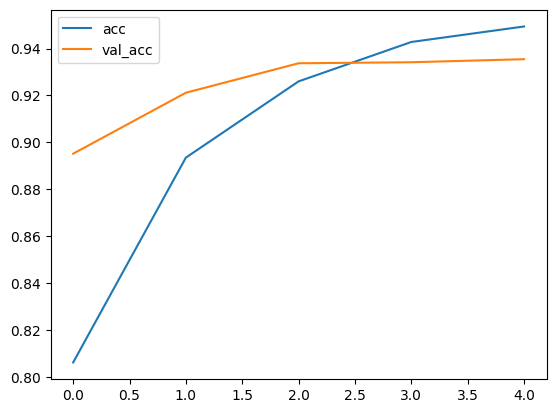

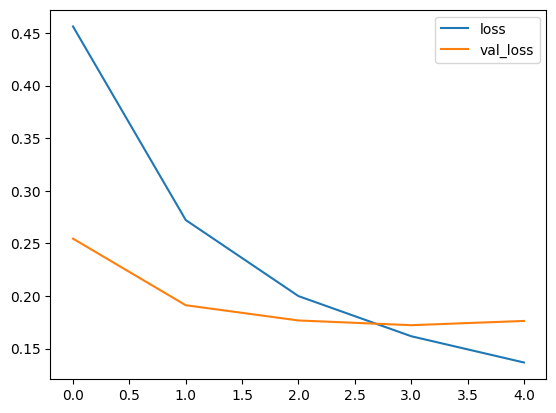

In [15]:
plt.plot(history.history['accuracy'], label= 'acc')
plt.plot(history.history['val_accuracy'], label= 'val_acc')

plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend()
plt.show()

In [16]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw, maxlen= 200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])

test_sentence1 = "I enjoyed my journey on this flight."
predict_sentiment(test_sentence1)

test_sentence2 = "This is the worst flight experience of my life!"
predict_sentiment(test_sentence2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
Predicted label:  positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Predicted label:  negative
